<a href="https://colab.research.google.com/github/SkyttRPS/DataAnalysisInMusic/blob/main/DeepSpeechAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Emotion Recognition
In order to import our data set to colaboratory, we need to run a set of commands to install kaggle, make a directory, copy the API kaggle.json file, give permissions, download the data set and finally unzip it.



In [ ]:
! pip install --upgrade pip

In [ ]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

In [ ]:
! unzip /content/ravdess-emotional-speech-audio.zip

In [ ]:
! pip install tensorflow

# RAVDESS Dataset
The employed dataset is the RAVDESS dataset provided on [Kaggle](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio).

The documentation provides information about the files, their naming convention, sample size and type. 1440 files, 24 actors vocalizing two lexically matched statements in neutral North American Accent.

The filenames are unique to a set of identifiers that are given a numerical value corresponding to the following documentation:

*   Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
*   Vocal channel (01 = speech, 02 = song).
*   Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*   Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
*   Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
*   Repetition (01 = 1st repetition, 02 = 2nd repetition).
*   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

*Example file: 03-01-08-01-01-02-11.wav*

1.   Audio-only (03)
2.   Speech (01)
3.   Surprised (08)
4.   Normal (01)
5.   Statement "Kids" (01)
6.   2nd Repetition (02)
7.   Actor 11 (11)
     Male, as the ID is odd.

**How to cite the RAVDESS dataset**

*Academic citation*

If you use the RAVDESS in an academic publication, please use the following citation: 
Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

# Importing libraries

In [10]:
# Libraries used for Data Analysis
import pandas as pd
import numpy as np

# Libraries used to navigate, manipulate and use data in the operating file system
import os
import sys

# Librosa lets us use Python for extracting and analysing data from audio files
import librosa
import librosa.display

# Seaborn and matplotlib are libraries used for plotting data into informative graphs
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn is a library used to perform machine learning processes 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# IPython is a Jupyter based library which we use to play audio in the notebook
import IPython.display as ipd

# TensorFlow is the platform that opens possibilites for end-to-end machine learning, Keras is the framework used 
#from tensorflow import keras
#from keras.callbacks import ReduceLROnPlateau
#from keras.models import Sequential
#from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
#from keras.utils import np_utils
#from tensorflow.keras.utils import to_categorical
#from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
  warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Preparing the dataset

In [ ]:
# Making sure we can access the dataset directory 
# RAVDESS set path
RAVDESS = "/content/audio_speech_actors_01-24/"

# Creating a directory list of the data set to make sure the data is accesible
directory_list = os.listdir(RAVDESS)
directory_list.sort()
directory_list[0:24]

In [18]:
# Re-do of the directory list into a more convenient variable name
dlist = os.listdir(RAVDESS)
dlist.sort()

# Creating three empty array lists to store emotion, and file path
emotion = []
path = []

# Looping through the directory
for i in dlist:
    fname = os.listdir(RAVDESS + i)
    for file in fname:
        # Splitting the string to read the identifiers from the file name
        part = file.split('.')[0]
        part = part.split('-')
        # The documentations tells the third part of the file represents the emotion
        emotion.append(int(part[2])) 
        path.append(RAVDESS + i + '/' + file)

# Setting up a datafarme for the output
# Dataframe for the emotion of files
emotion_df = pd.DataFrame(emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,sad,/content/audio_speech_actors_01-24/Actor_01/03...
1,fear,/content/audio_speech_actors_01-24/Actor_01/03...
2,surprise,/content/audio_speech_actors_01-24/Actor_01/03...
3,calm,/content/audio_speech_actors_01-24/Actor_01/03...
4,angry,/content/audio_speech_actors_01-24/Actor_01/03...


Converting the dataset to a set of comma seperated values

In [21]:
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,sad,/content/audio_speech_actors_01-24/Actor_01/03...
1,fear,/content/audio_speech_actors_01-24/Actor_01/03...
2,surprise,/content/audio_speech_actors_01-24/Actor_01/03...
3,calm,/content/audio_speech_actors_01-24/Actor_01/03...
4,angry,/content/audio_speech_actors_01-24/Actor_01/03...


#Visualising the data

In order to implement and apply our deep neural netowrk, we need to visualise it in a format that can be recognized by the architecture. 

Prior to the visualisation, we make sure the audio is playable on the notebook, to crosscheck with the dataframe
*   **Waveplots** are used to visualise the audio levels or loudness through time in the file
*   **Spectrograms** are used to visualise a spectrum of frequencies of time from an audio signal



In [52]:
# Defining function for creating a waveplot
def create_wplot(data, sr, emotion):
    plt.figure(figsize=(15, 5))
    plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

# Defining function for creating a spectrogram
def create_spectrogram(data, sr, emotion):
    # sftf is a Librosa function used to apply fourier transformation
    # Fourier transformation is a mathematical function used to break a signal into a time/frequency space
    x = librosa.stft(data)
    db = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(15, 5))
    plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=15)
    
    # Librosa function for displaying a generated spectrogram
    librosa.display.specshow(db, sr=sr, x_axis='time', y_axis='hz')   
    # adding a colourbar to indicate signal decibel levels
    plt.colorbar()

# Visualising emotion

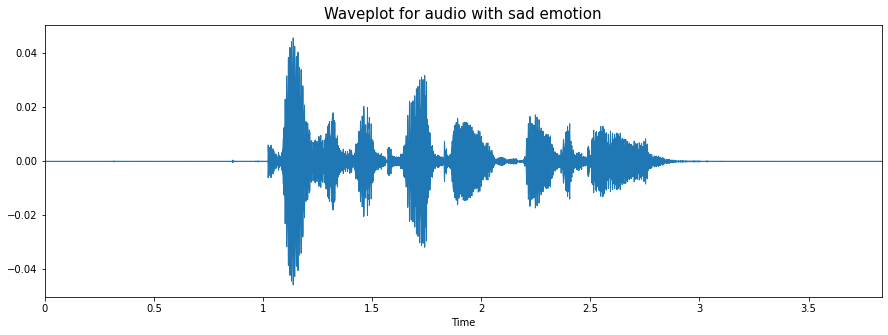

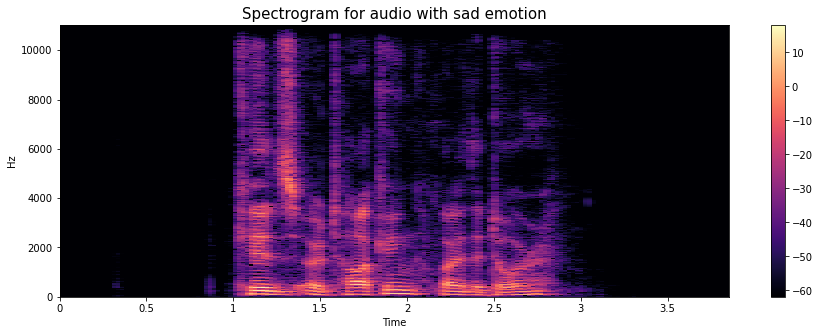

In [53]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_wplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path)